In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import os
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Flatten, BatchNormalization, Dropout, MaxPooling2D, Conv2D, Activation, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.advanced_activations import PReLU

Reading table with info about images. All images have number names, like 1234.png, 345.png. We need to get their styles from this table

In [2]:
paintings = pd.read_csv("train_info.csv")
paintings.head(15)

,filename,artist,title,style,genre,date
0,102257.jpg,5b39c876740bfc1cfaf544721c43cac3,Uriel,Color Field Painting,abstract,1955.0
1,75232.jpg,5b39c876740bfc1cfaf544721c43cac3,Vir Heroicus Sublimis,Color Field Painting,abstract,1950.0
2,29855.jpg,96e5bc98488ed589b9bf17ad9fd09371,Night March of a Hundred Demons (left half),Yamato-e,mythological painting,NaN
3,62252.jpg,5b39c876740bfc1cfaf544721c43cac3,"Who’s Afraid of Red, Yellow and Blue II",Color Field Painting,abstract,NaN
4,63861.jpg,5b39c876740bfc1cfaf544721c43cac3,Black Fire I,Color Field Painting,abstract,1963.0
5,53180.jpg,782192dc825c7c1149825adcb7caacbc,Camellia and Bush Warbler,Ukiyo-e,bird-and-flower painting,1844
6,70944.jpg,afdfc43410410892bc9d1c4d3c3d6220,Forbidden Land,Surrealism,landscape,1937.0
7,59792.jpg,9f0984ce62483f294fc666d74e0974f6,Descent from the cross,Northern Renaissance,religious painting,NaN
8,48138.jpg,3a40b18a78ceb822961393c50bdb522b,Snowy landscape with a woman brandishing a bro...,Ukiyo-e,landscape,NaN
9,99442.jpg,d09f796f2b0aa11dffc88badd9806119,Storm at sea,Romanticism,marina,1873


In [3]:
paintings = paintings[["filename", "style"]]
styles = {"Art Nouveau (Modern)": 0, "Realism": 1, "Symbolism": 2, "Impressionism": 3, "Ukiyo-e": 4, "Cubism": 5}
paintings = paintings.loc[paintings['style'].isin(styles)]
print(paintings["style"].unique())
paintings.head(10)

['Ukiyo-e' 'Realism' 'Cubism' 'Symbolism' 'Art Nouveau (Modern)'
 'Impressionism']


,filename,style
5,53180.jpg,Ukiyo-e
8,48138.jpg,Ukiyo-e
10,23508.jpg,Ukiyo-e
12,27254.jpg,Ukiyo-e
13,47145.jpg,Ukiyo-e
16,28908.jpg,Realism
21,71024.jpg,Ukiyo-e
23,71435.jpg,Cubism
26,63416.jpg,Cubism
29,4147.jpg,Cubism


In [4]:
paintings["style"].value_counts()

Impressionism           8220
Realism                 8112
Art Nouveau (Modern)    3779
Symbolism               2626
Cubism                  1316
Ukiyo-e                 1137
Name: style, dtype: int64

In [5]:
def load_images(folder):
    images = []
    stl = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.resize(img, (256, 256))
        if img is not None and filename in paintings["filename"].unique():
            images.append(img)
            stl.append(styles[paintings.loc[paintings['filename'] == filename, 'style'].iloc[0]])
    return images, stl

img_list, im_styles =load_images("train_2")

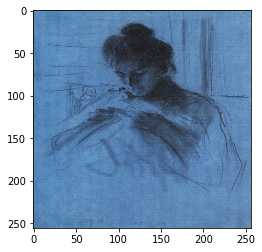

Realism


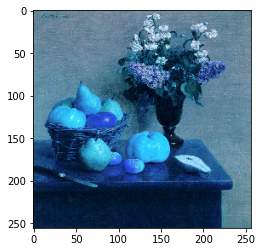

Realism


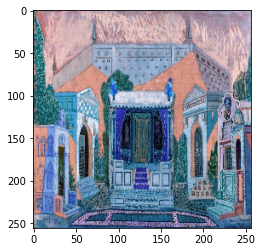

Cubism


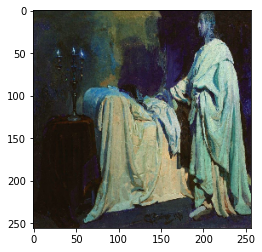

Realism


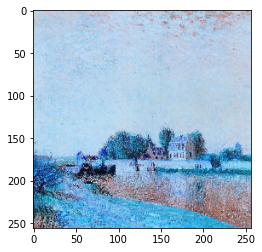

Impressionism


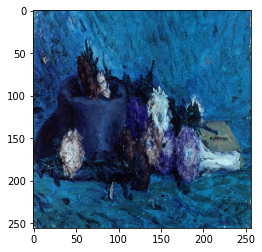

Impressionism


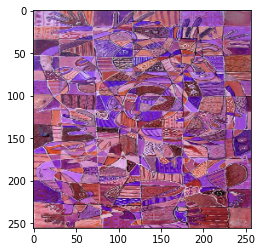

Cubism


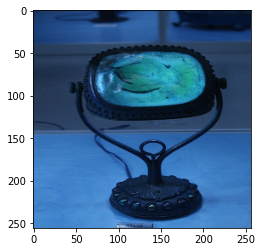

Art Nouveau (Modern)


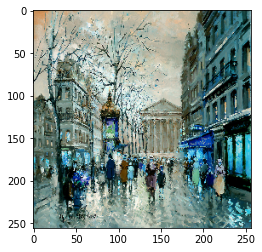

Impressionism


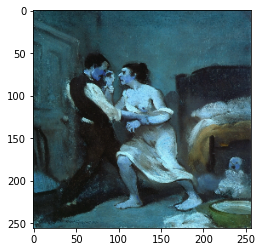

Impressionism


In [6]:
for image, num in zip(img_list[:10], im_styles[:10]):
    plt.imshow(image)
    plt.show()
    print(list(styles.keys())[list(styles.values()).index(num)])

In [10]:
def model_cnn(in_shape=(256, 256, 3)):
    model = Sequential()
    
    model.add(Conv2D(16, (3, 3), input_shape=in_shape, padding='same'))
    model.add(BatchNormalization(axis=1, momentum=2))
    model.add(PReLU('he_normal'))
    model.add(Conv2D(16, (3, 3), padding='same'))
    model.add(BatchNormalization(axis=1, momentum=2))
    model.add(PReLU('he_normal'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization(axis=1, momentum=2))
    model.add(PReLU('he_normal'))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization(axis=1, momentum=2))
    model.add(PReLU('he_normal'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization(axis=1, momentum=2))
    model.add(PReLU('he_normal'))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization(axis=1, momentum=2))
    model.add(PReLU('he_normal'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization(axis=1, momentum=2))
    model.add(PReLU('he_normal'))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization(axis=1, momentum=2))
    model.add(PReLU('he_normal'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Dropout(rate=0.5))
    model.add(Flatten())
    model.add(Dense(6, activation='relu', kernel_initializer='he_normal'))
    model.add(BatchNormalization(momentum=2))
    model.add(PReLU('he_normal'))

    model.add(Dense(6, activation='softmax'))
    model.add(BatchNormalization(momentum=2))
    model.add(Activation(activation='softmax'))
    adam = Adam(learning_rate=0.000074)
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=adam,
        metrics=['accuracy'])
    return model

In [8]:
# def train(model, train_loader, optimizer):
#     model.train()
#     for batch_idx, (data, target) in enumerate(train_loader):
#         optimizer.zero_grad()
#         output = model(data)
#         loss = F.cross_entropy(output, target)
#         loss.backward()
#         optimizer.step()
         
        
# def test(model, val_loader):
#     model.eval()
#     valid_loss = 0.0
#     criterion = nn.CrossEntropyLoss()
#     correct = 0
#     total = 0

#     for data, labels in val_loader:
#         target = model(data)
#         loss = criterion(target, labels)
#         valid_loss = loss.item() * data.size(0)
#         correct += torch.sum(target.argmax(-1) == labels).item()
#         total += labels.size(0)

In [ ]:
model = model_cnn()
trainX, testX, trainY, testY = train_test_split(img_list, im_styles, test_size=0.2, random_state=1)
trainX = np.array(img_list)
testX = np.array(testX)
trainY = np.asarray(im_styles).astype('float32').reshape((-1,1))
testY = np.asarray(testY).astype('float32').reshape((-1,1))


# datagen = ImageDataGenerator(rescale=1./255)
# train_it = datagen.flow(trainX, trainY, batch_size=128)
# test_it = datagen.flow(testX, testY, batch_size=128)

h = model.fit(trainX, trainY, batch_size=32, epochs=3, validation_split=0.3)

#history_model = model.fit(trainX, trainY, epochs=5, batch_size=32, verbose=1, validation_data=(testX, testY))

Epoch 1/3
59/59 [==============================] - 545s 9s/step - loss: 2.0615 - accuracy: 0.2179 - val_loss: nan - val_accuracy: 0.1566
Epoch 2/3
59/59 [==============================] - 537s 9s/step - loss: 1.8653 - accuracy: 0.2776 - val_loss: nan - val_accuracy: 0.1566
Epoch 3/3
44/59 [=====================>........] - ETA: 2:10 - loss: 1.8143 - accuracy: 0.2898

In [57]:
h.history['accuracy']

[0.12235294282436371,
 0.23764705657958984,
 0.27482351660728455,
 0.31482353806495667,
 0.3477647006511688]

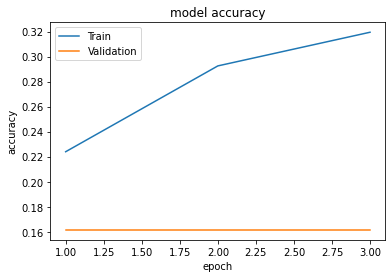

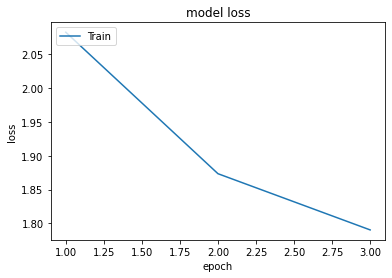

In [12]:
plt.plot([1, 2, 3], h.history['accuracy'])
plt.plot([1, 2, 3], h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot([1, 2, 3], h.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [18]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow(testX, testY, batch_size=32)
train_data_generator = test_generator.flow(trainX, trainY, batch_size=32)

#test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model.predict_generator(test_data_generator, steps=len(test_data_generator))
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

<ipython-input-18-94a1f14d9638>:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_data_generator, steps=len(test_data_generator))
